In [3]:
import numpy as np
from numpy.random import multivariate_normal as mvn

import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import minimize

from math import log
from math import dist
from math import floor

from random import shuffle

from tqdm import tqdm

from weights import KNN
from weights import proximity

from accuracy import KNN_acc
from accuracy import Prox_acc

# Complete Three Cluster Example

## Generating the Points

We first write a function to generate three well-separated clusters, depending on the number of points desired and the centers and covariance matrix of the distributions

In [4]:
def clusters(m3, centers, covar):
	# m3 is the number of points around each distribution

	knownvals = [int(j*m3) for j in range(3)] # Points for which we know the value of the label

	X = mvn(centers[0],covar, m3)
	X = np.append(X,mvn(centers[1],covar, m3), axis=0)
	X = np.append(X,mvn(centers[2],covar, m3), axis=0)

	y = [1 for i in range(m3)]
	y = y + [-1 for i in range(2*m3)]

	return X, y, knownvals

We use this to generate the points

In [5]:
M = 300 # Multiple of 3

centers = [[0,0],[1,0],[1,1]]
covar = 0.01*np.identity(2)

X, y, knownvals = clusters(int(M/3), centers, covar)

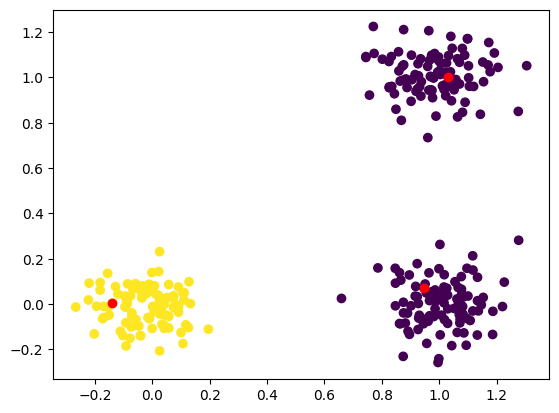

In [6]:
xs = X[:,0]
ys = X[:,1]

xs_k = [xs[j] for j in knownvals]
ys_k = [ys[j] for j in knownvals]

plt.scatter(xs, ys, c=y, cmap = "viridis")
plt.scatter(xs_k, ys_k, color="red")

## Build a Graph on the Points and Run Regression

To build a graph on the points, we have some choices to make: the choice of weight function and its parameters and whether we use a KNN approach or a full proximity graph approach

Here is an example of some of these graphs

### KNN with uniform kernel

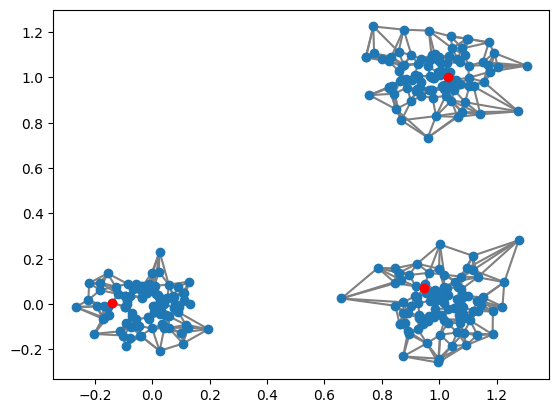

In [7]:
unif = lambda x1, x2: 1
k = 5

L, W = KNN(X, M, k, unif)

plt.scatter(xs, ys)
plt.scatter(xs_k, ys_k, color="red")

for i in range(M):
	for j in range(i,M):
		if W[i,j] > 0:
			plt.plot([X[i,0],X[j,0]],[X[i,1],X[j,1]], color = "gray", zorder = 0)

Performing the classification, we see that the model performs well with both probit and regression loss. Note that it was not necessary to tune parameters to get good results.

In [8]:
def probit(kvals, y, f): # Probits Loss
	return -sum([log(norm.cdf(y[j]*f[j])) for j in kvals])

def regression(kvals, y, f): # Regression Loss
	return sum([(y[j]-f[j])**2 for j in kvals])

def regular(lamb,C_inv,f): # Regularization
	f_T = np.array(f).T
	return lamb*f_T.dot(C_inv).dot(f)

def to_minimize(f,kvals,y,lamb,C_inv, loss): # Funtional to minimize
    return loss(kvals,y,f) + regular(lamb,C_inv,f)

In [9]:
tau = 1
alpha = 2
lamb = (tau**(2*alpha))/2
C = np.linalg.matrix_power(((L + (tau**2)*np.eye(M))),-alpha)
C_inv = np.linalg.inv(C)

#### Probit Loss

In [10]:
loss = probit

f0 = np.zeros(M)
result = minimize(to_minimize, f0, args=(knownvals,y,lamb,C_inv,loss), method='BFGS') # Perform minimization

f_star = result.x
y_pred = np.sign(f_star) # Predicted labels

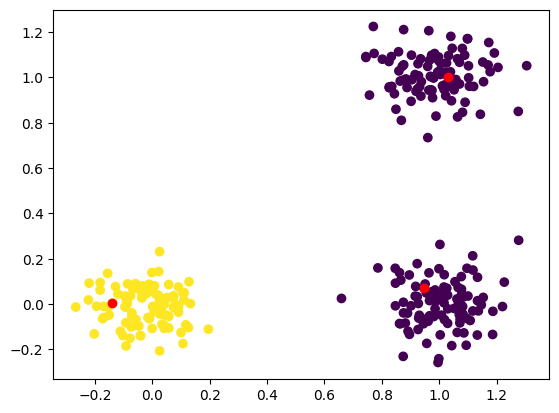

In [11]:
xs = X[:,0]
ys = X[:,1]

xs_k = [xs[j] for j in knownvals]
ys_k = [ys[j] for j in knownvals]

plt.scatter(xs, ys, c=y_pred, cmap = "viridis")
plt.scatter(xs_k, ys_k, color="red")

In [12]:
accuracy = sum([x[0] == x[1] for x in zip(y_pred,y)])/M
print(accuracy)

1.0


#### Regression Loss

In [13]:
loss = regression

f0 = np.zeros(M)
result = minimize(to_minimize, f0, args=(knownvals,y,lamb,C_inv,loss), method='BFGS') # Perform minimization

f_star = result.x
y_pred = np.sign(f_star) # Predicted labels

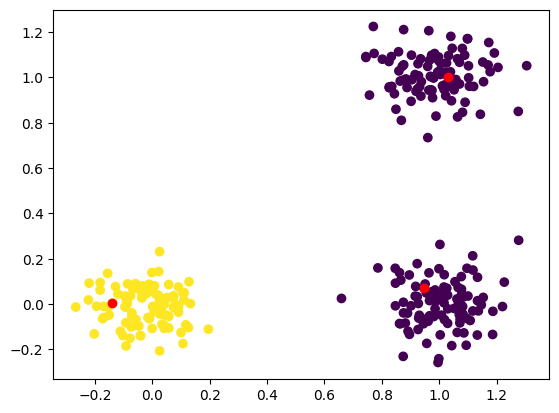

In [14]:
xs = X[:,0]
ys = X[:,1]

xs_k = [xs[j] for j in knownvals]
ys_k = [ys[j] for j in knownvals]

plt.scatter(xs, ys, c=y_pred, cmap = "viridis")
plt.scatter(xs_k, ys_k, color="red")

In [15]:
accuracy = sum([x[0] == x[1] for x in zip(y_pred,y)])/M
print(accuracy)

1.0


### Proximity with RBF Kernel

We first need to make a guess at the gamma parameter in the RBF kernel. We use the first quartile of the distances between vertices. Then we adjust using our multplier

In [16]:
dists = []
for x1 in X:
	for x2 in X:
		dists += [dist(x1,x2)]
dists.sort()

mult = 16
gamma = dists[floor(len(dists)/4)]*mult

rbf = lambda x1, x2: np.exp(gamma**2*-0.5*dist(x1,x2)**2)

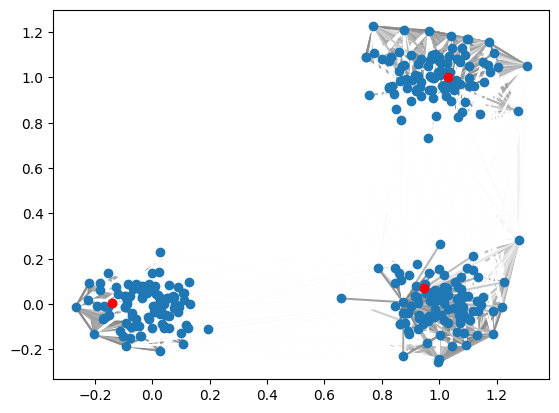

In [17]:
L, W = proximity(X, M, 2, rbf)

plt.scatter(xs, ys)
plt.scatter(xs_k, ys_k, color="red")

l1 = [*range(M)] # Shuffle vertices to make plot more even
shuffle(l1)
l2 = [*range(M)]
shuffle(l2)

for i in l1:
	for j in l2:
		if W[i,j] > 0:
			plt.plot([X[i,0],X[j,0]],[X[i,1],X[j,1]], color = str(1 - 0.5*W[i,j]), zorder = 0)

Now we do the classification

We need to tune the tau parameter here, we want tau^2 to be on the order of epsilon

In [18]:
W2 = np.copy(W)
W2 = W2.flatten()
W2.sort()
tau = W2[floor(len(W2)/2)]**(1/2)

In [19]:
alpha = 2
lamb = (tau**(2*alpha))/2
C = np.linalg.matrix_power(((L + (tau**2)*np.eye(M))),-alpha)
C_inv = np.linalg.inv(C)

#### Probit Loss

In [20]:
loss = probit

f0 = np.zeros(M)
result = minimize(to_minimize, f0, args=(knownvals,y,lamb,C_inv,loss), method='BFGS') # Perform minimization

f_star = result.x
y_pred = np.sign(f_star) # Predicted labels

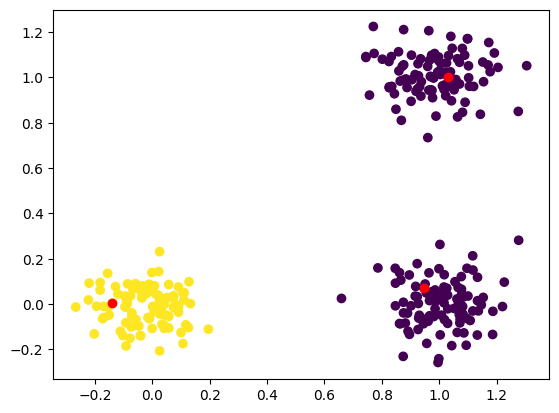

In [21]:
xs = X[:,0]
ys = X[:,1]

xs_k = [xs[j] for j in knownvals]
ys_k = [ys[j] for j in knownvals]

plt.scatter(xs, ys, c=y_pred, cmap = "viridis")
plt.scatter(xs_k, ys_k, color="red")

In [22]:
accuracy = sum([x[0] == x[1] for x in zip(y_pred,y)])/M
print(accuracy)

1.0


### Regression Loss

In [23]:
loss = regression

f0 = np.zeros(M)
result = minimize(to_minimize, f0, args=(knownvals,y,lamb,C_inv,loss), method='BFGS') # Perform minimization

f_star = result.x
y_pred = np.sign(f_star) # Predicted labels

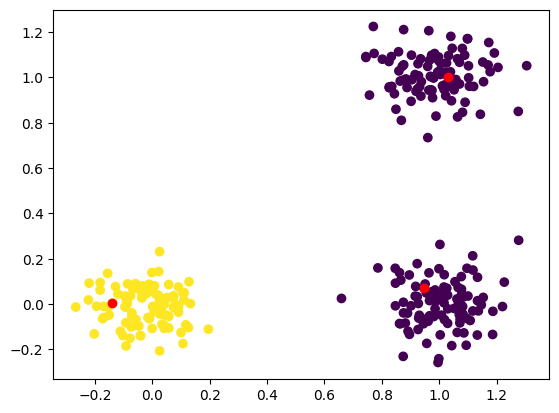

In [24]:
xs = X[:,0]
ys = X[:,1]

xs_k = [xs[j] for j in knownvals]
ys_k = [ys[j] for j in knownvals]

plt.scatter(xs, ys, c=y_pred, cmap = "viridis")
plt.scatter(xs_k, ys_k, color="red")

In [25]:
accuracy = sum([x[0] == x[1] for x in zip(y_pred,y)])/M
print(accuracy)

1.0


## Validation of accuracy with multiple trials

We run this process 50 times for each case to confirm this result

### KNN Graph

In [ ]:
M = 300 # Multiple of 3

centers = [[0,0],[1,0],[1,1]]
covar = 0.01*np.identity(2)

k = 5
tau = 1
alpha = 2
lamb = (tau**(2*alpha))/2

sum_acc = 0
for j in tqdm(range(50)):
	X, y, knownvals = clusters(int(M/3), centers, covar)

	sum_acc += KNN_acc(X, y, knownvals, alpha = alpha, tau = tau, lossf = "probit", k = k, kernel = unif)

probit_accuracy = sum_acc/50

sum_acc = 0
for j in tqdm(range(50)):
	X, y, knownvals = clusters(int(M/3), centers, covar)

	sum_acc += KNN_acc(X, y, knownvals, alpha = alpha, tau = tau, lossf = "regression", k = k, kernel = unif)

regression_accuracy = sum_acc/50

100%|██████████| 50/50 [04:40<00:00,  5.62s/it]

1.0
1.0


In [ ]:
print(probit_accuracy)
print(regression_accuracy)

1.0
1.0


### Proximity Graph

In [26]:
M = 300 # Multiple of 3

centers = [[0,0],[1,0],[1,1]]
covar = 0.01*np.identity(2)

tau = 1
alpha = 2
lamb = (tau**(2*alpha))/2

sum_acc = 0
for j in tqdm(range(50)):
	X, y, knownvals = clusters(int(M/3), centers, covar)

	dists = []
	for x1 in X:
		for x2 in X:
			dists += [dist(x1,x2)]
	dists.sort()

	mult = 16
	gamma = dists[floor(len(dists)/4)]*mult

	rbf = lambda x1, x2: np.exp(gamma**2*-0.5*dist(x1,x2)**2)

	L, W = proximity(X, M, 2, rbf)

	W2 = np.copy(W)
	W2 = W2.flatten()
	W2.sort()
	tau = W2[floor(len(W2)/2)]**(1/2)
	
	alpha = 2
	lamb = (tau**(2*alpha))/2
	C = np.linalg.matrix_power(((L + (tau**2)*np.eye(M))),-alpha)
	C_inv = np.linalg.inv(C)

	loss = probit

	f0 = np.zeros(M)
	result = minimize(to_minimize, f0, args=(knownvals,y,lamb,C_inv,loss), method='BFGS') # Perform minimization

	f_star = result.x
	y_pred = np.sign(f_star) # Predicted labels

	sum_acc += sum([x[0] == x[1] for x in zip(y_pred,y)])/M

probit_accuracy = sum_acc/50

sum_acc = 0
for j in tqdm(range(50)):
	X, y, knownvals = clusters(int(M/3), centers, covar)

	dists = []
	for x1 in X:
		for x2 in X:
			dists += [dist(x1,x2)]
	dists.sort()

	mult = 16
	gamma = dists[floor(len(dists)/4)]*mult

	rbf = lambda x1, x2: np.exp(gamma**2*-0.5*dist(x1,x2)**2)

	L, W = proximity(X, M, 2, rbf)

	W2 = np.copy(W)
	W2 = W2.flatten()
	W2.sort()
	tau = W2[floor(len(W2)/2)]**(1/2)
	
	alpha = 2
	lamb = (tau**(2*alpha))/2
	C = np.linalg.matrix_power(((L + (tau**2)*np.eye(M))),-alpha)
	C_inv = np.linalg.inv(C)

	loss = regression

	f0 = np.zeros(M)
	result = minimize(to_minimize, f0, args=(knownvals,y,lamb,C_inv,loss), method='BFGS') # Perform minimization

	f_star = result.x
	y_pred = np.sign(f_star) # Predicted labels

	sum_acc += sum([x[0] == x[1] for x in zip(y_pred,y)])/M

regression_accuracy = sum_acc/50

100%|██████████| 50/50 [04:18<00:00,  5.17s/it]


In [27]:
print(probit_accuracy)
print(regression_accuracy)

1.0
1.0


We can see that with the choices made above, both the disconnected and O(Eps) graphs classify the data with 100% accuracy